In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gvar as gv

In [2]:
import h5py
import lsqfit
import h5data_methods


In [3]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885

# Array of tsep values
tsep_vals = np.arange(3,13,1)

In [32]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(n_selec):
        Ea += p['dE{}'.format(l)]
        
    print(Ea)
    return Ea

In [33]:
# Load data
data = gv.BufferDict()
data['2pt'] = h5data_methods.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt'] = h5data_methods.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)

gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

In [34]:
# Calculate the ratio between 3-point and 2-point data
gv_avg_data['C_ratio'] = np.array([ [gv_avg_data['3pt'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum'] = np.array([np.sum(gv_avg_data['3pt'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH'] = np.array([ (gv_avg_data['Csum'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)]) 
                                

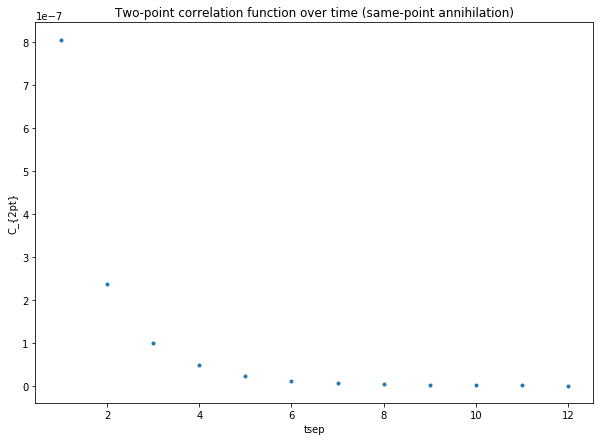

<Figure size 432x288 with 0 Axes>

In [35]:
# Plot the 2-point correlation: same-point only
x_2pt = np.array([i for i in range (1, 13)])
y_2pt = np.array([gv_avg_data['2pt_SS'][i].mean for i in range (1, 13)])
y_2pt_err = np.array([gv_avg_data['2pt_SS'][i].sdev for i in range (1, 13)])

h5data_methods.raw_data_plot("Two-point correlation function over time (same-point annihilation)", "tsep", "C_{2pt}", x_2pt, y_2pt, yerror=y_2pt_err)

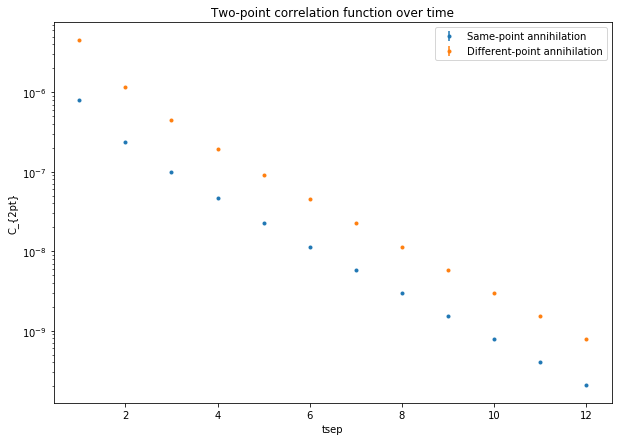

<Figure size 432x288 with 0 Axes>

In [36]:
# Plot the 2-point correlation: log plot

x_2pt = np.array([[i for i in range (1, 13)], [i for i in range (1, 13)]])
y_2pt = np.array([[gv_avg_data['2pt_SS'][i].mean for i in range (1, 13)], [gv_avg_data['2pt_PS'][i].mean for i in range (1, 13)]])
y_2pt_err = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in range (1, 13)], [gv_avg_data['2pt_PS'][i].sdev for i in range (1, 13)]])

l = np.array(["Same-point annihilation", "Different-point annihilation"])

h5data_methods.raw_data_plot("Two-point correlation function over time", "tsep", "C_{2pt}", x_2pt, y_2pt, nplots=2, yerror=y_2pt_err, legendlabels=l, logy=True)



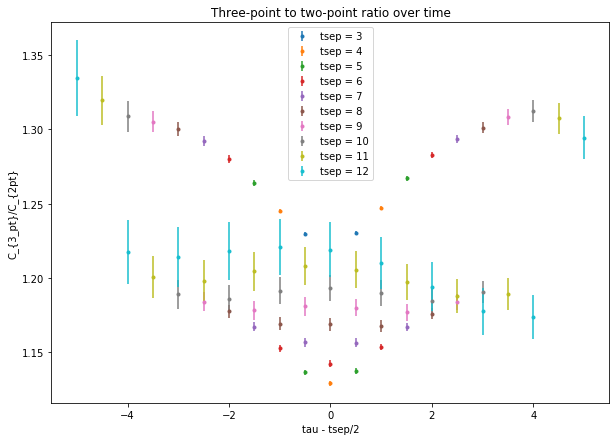

<Figure size 432x288 with 0 Axes>

In [37]:
# 3-point to 2-point ratio plots
x_3pt = np.array([np.array([j - (i+3)/2. for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])
y_3pt = np.array([ np.array([gv_avg_data['C_ratio'][i][j].mean for j in range(len(gv_avg_data['C_ratio'][i]))]) for i in range(len(tsep_vals))])
y_3pt_err = np.array([ np.array([gv_avg_data['C_ratio'][i][j].sdev for j in range(len(gv_avg_data['C_ratio'][i]))]) for i in range(len(tsep_vals))])

#for j in range(len(gv_avg_data['C_ratio'][i]))

legendlabels = np.array(["tsep = {}".format(i) for i in tsep_vals])

h5data_methods.raw_data_plot("Three-point to two-point ratio over time", "tau - tsep/2", 'C_{3_pt}/C_{2pt}', x_3pt, y_3pt, nplots = len(gv_avg_data['C_ratio']), yerror=y_3pt_err, legendlabels=legendlabels)


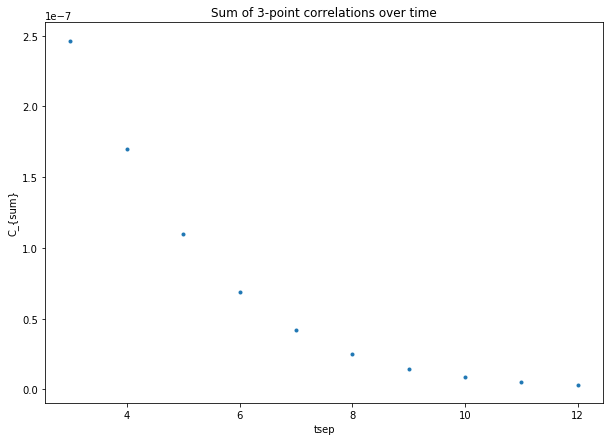

<Figure size 432x288 with 0 Axes>

In [38]:
# Plot Csum
x_Csum = np.array([i for i in tsep_vals ])
y_Csum = np.array([gv_avg_data['Csum'][i].mean for i in range(len(tsep_vals))])
y_Csum_err = np.array([gv_avg_data['Csum'][i].sdev for i in range(len(tsep_vals))])

h5data_methods.raw_data_plot("Sum of 3-point correlations over time", "tsep", "C_{sum}", x_Csum, y_Csum, yerror=y_Csum_err)


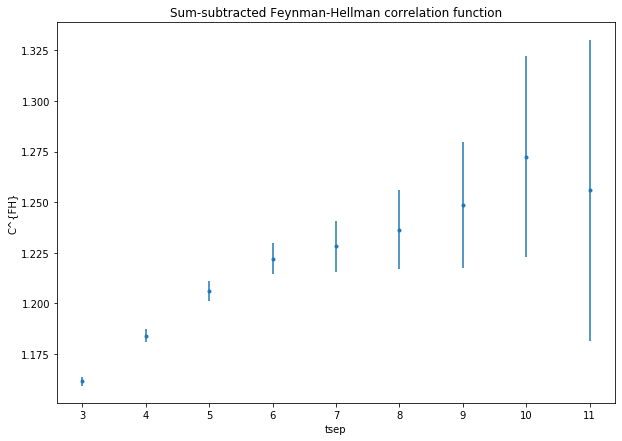

<Figure size 432x288 with 0 Axes>

In [39]:
# Plot Feynman-Hellman
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH = np.array([gv_avg_data['C^FH'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_err = np.array([gv_avg_data['C^FH'][i].sdev for i in range(len(tsep_vals)-1)])

h5data_methods.raw_data_plot("Sum-subtracted Feynman-Hellman correlation function", "tsep", "C^{FH}", x_CFH, y_CFH, yerror=y_CFH_err)



In [40]:
# the 3-point correlation function
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
num_zs = 1
def C_3pt(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    print("tsep: ", tsep)
    print("tau: ", tau)
    
    result = np.array([gv.gvar(0,0) for i in range(len(tsep))])
    for n in range(num_zs):
        for m in range(num_zs):
            En = Ei(n, p)
            Em = Ei(m, p)
            result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

In [41]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0] - 1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 


# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    
#print(np.shape(t_2d_array))
#print(np.shape(t_1d_array))

In [42]:
# In order to test, set priors
num_zs = 6


priors = gv.BufferDict()
for n in range(num_zs):
    for m in range(num_zs):
        priors['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
    
priors['gA3_00'] = gv.gvar(1.25, 0.15) # Prior the ground state on the 3-point-to-2-point ratios

priors['E0'] = gv.gvar(0.665, 0.015)
priors['Z0'] = gv.gvar(0.0008, 0.0003)
priors['Ztilde0'] = gv.gvar(0.003, 0.002)

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

E0_errbar = 0.8
energyvals[0] = priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]
        

for k in range(1, num_zs):
            
    err_ratio = energyvals[k]/(energyvals[k] - (E0_errbar * dEvals[k-1]) )
            
    priors['Z{}'.format(k)] = gv.gvar(0.0008, 0.0004)
    priors['Ztilde{}'.format(k)] = gv.gvar(0, 0.005)
    priors['log(dE{})'.format(k-1)] = gv.gvar(np.log(dEvals[k-1]), 0.7)

In [43]:
# Set some t-vals, then test
num_zs = 6

#print(np.shape(test_t))
#print(test_t)
#for i in range(len(tsep_vals)):
    #for j in range(1, i+tsep_vals[0]):
        #test_t[i][j-1][0] = i+tsep_vals[0]
        #test_t[i][j-1][1] = j


        
#print(test_t)
#print(test_t[0][0][0])
test_C = C_3pt(t_1d_array, priors)

tsep:  [ 3.  3.  4.  4.  4.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.
  7.  7.  8.  8.  8.  8.  8.  8.  8.  9.  9.  9.  9.  9.  9.  9.  9. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
tau:  [ 1.  2.  1.  2.  3.  1.  2.  3.  4.  1.  2.  3.  4.  5.  1.  2.  3.  4.
  5.  6.  1.  2.  3.  4.  5.  6.  7.  1.  2.  3.  4.  5.  6.  7.  8.  1.
  2.  3.  4.  5.  6.  7.  8.  9.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.
  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
0.665(15)
0.665(15)
0.665(15)
1.04(26)
0.665(15)
1.42(37)
0.665(15)
1.80(46)
0.665(15)
2.17(53)
0.665(15)
2.55(59)
1.04(26)
0.665(15)
1.04(26)
1.04(26)
1.04(26)
1.42(37)
1.04(26)
1.80(46)
1.04(26)
2.17(53)
1.04(26)
2.55(59)
1.42(37)
0.665(15)
1.42(37)
1.04(26)
1.42(37)
1.42(37)
1.42(37)
1.80(46)
1.42(37)
2.17(53)
1.42(37)
2.55(59)
1.80(46)
0.665(15)
1.80(46)
1.04(26)
1.80(46)
1.42(37)
1.80(46)
1.80(46)
1.80(46)
2.17(53)
1.80(46)
2.55(59)
2.17(53)
0.665(

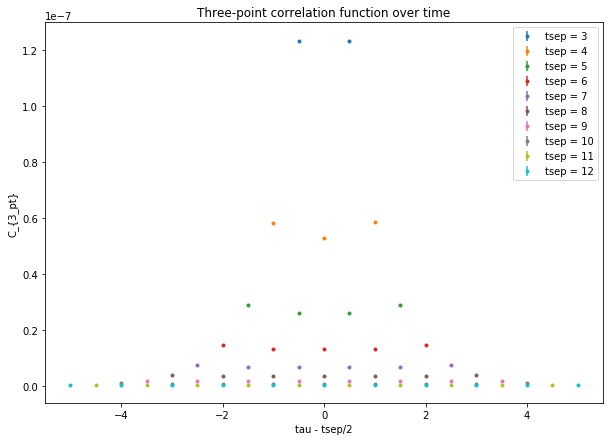

<Figure size 432x288 with 0 Axes>

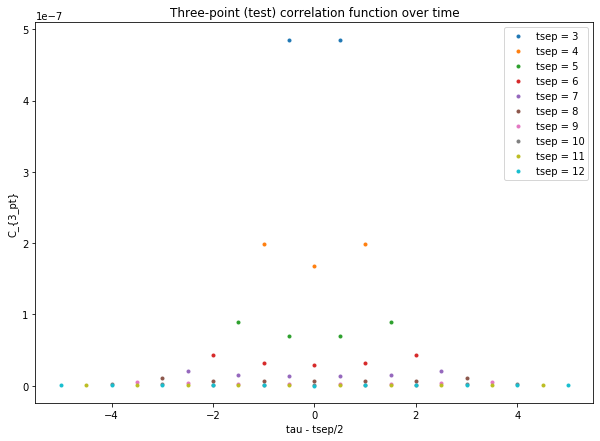

<Figure size 432x288 with 0 Axes>

In [44]:
y_3pt_mean = np.array([[gv_avg_data['3pt'][i][j].mean for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_sdev = np.array([[gv_avg_data['3pt'][i][j].sdev for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])

y_test = convert_1dto2d(t_1d_array, t_2d_array, test_C)
y_test_mean = np.array([[y_test[i][j-1].mean for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_test_sdev = np.array([[y_test[i][j-1].sdev for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


h5data_methods.raw_data_plot("Three-point correlation function over time", "tau - tsep/2", 'C_{3_pt}', x_3pt, y_3pt_mean, nplots = len(gv_avg_data['C_ratio']), yerror=y_3pt_sdev, legendlabels=legendlabels) #ylim = (0, 1e-07),
h5data_methods.raw_data_plot("Three-point (test) correlation function over time", "tau - tsep/2", 'C_{3_pt}', x_3pt, y_test_mean, nplots = len(gv_avg_data['C_ratio']), legendlabels=legendlabels) #ylim = (0, 1e-07),


In [45]:
# test the ratio-finder
print(y_test)
print(test_C)

[array([4.9(3.8)e-07, 4.9(3.8)e-07], dtype=object)
 array([2.0(1.6)e-07, 1.7(1.4)e-07, 2.0(1.6)e-07], dtype=object)
 array([9.0(7.4)e-08, 6.9(5.9)e-08, 6.9(5.9)e-08, 9.0(7.4)e-08],
      dtype=object)
 array([4.3(3.6)e-08, 3.1(2.7)e-08, 2.9(2.5)e-08, 3.1(2.7)e-08,
       4.3(3.6)e-08], dtype=object)
 array([2.1(1.8)e-08, 1.5(1.3)e-08, 1.3(1.1)e-08, 1.3(1.1)e-08,
       1.5(1.3)e-08, 2.1(1.8)e-08], dtype=object)
 array([1.04(88)e-08, 7.3(6.2)e-09, 6.2(5.3)e-09, 5.9(5.0)e-09,
       6.2(5.3)e-09, 7.3(6.2)e-09, 1.04(88)e-08], dtype=object)
 array([5.2(4.4)e-09, 3.6(3.1)e-09, 3.1(2.6)e-09, 2.8(2.3)e-09,
       2.8(2.3)e-09, 3.1(2.6)e-09, 3.6(3.1)e-09, 5.2(4.4)e-09],
      dtype=object)
 array([2.7(2.3)e-09, 1.8(1.6)e-09, 1.5(1.3)e-09, 1.4(1.1)e-09,
       1.4(1.1)e-09, 1.4(1.1)e-09, 1.5(1.3)e-09, 1.8(1.6)e-09,
       2.7(2.3)e-09], dtype=object)
 array([1.3(1.2)e-09, 9.3(7.9)e-10, 7.7(6.4)e-10, 7.0(5.7)e-10,
       6.7(5.4)e-10, 6.7(5.4)e-10, 7.0(5.7)e-10, 7.7(6.4)e-10,
       9.3(7.9)e-10

In [56]:
# The Feynman-Hellman fit-function
# t is a numpy array of tsep times

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)


num_zs = 1
def Csum(t, p):
    result = 0
    for n in range(num_zs):
        print("n = ", n)
        En = Ei(n, p)
        
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(num_zs):
            if n == m:
                continue
            else:
                print("m = ", m)
                Em = Ei(m, p)
                
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH(t, p):
    return (Csum(t + 1, p)/C_2pt_SS(t + 1, p)) - (Csum(t, p)/C_2pt_SS(t, p))

n =  0
0.665(15)
0.665(15)
n =  0
0.665(15)
0.665(15)
(10,)


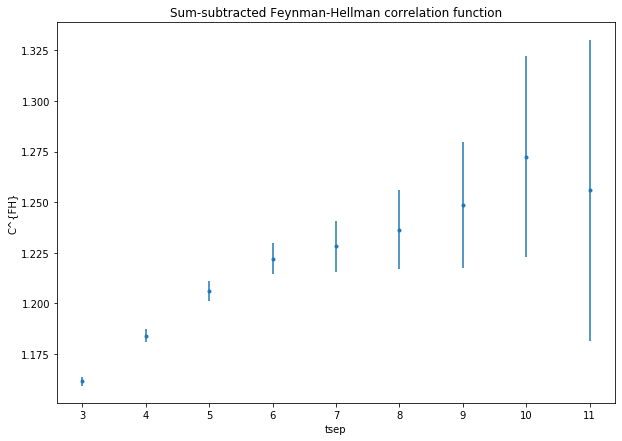

<Figure size 432x288 with 0 Axes>

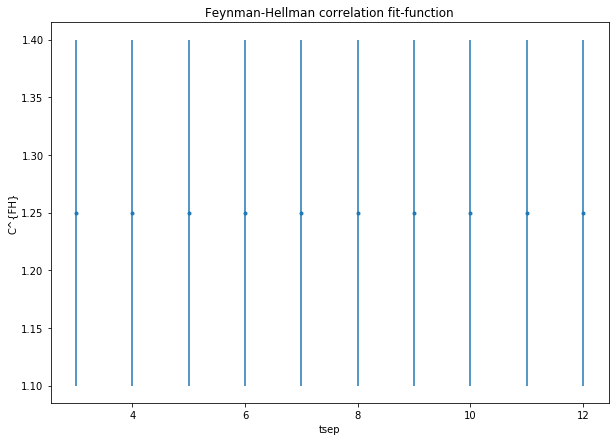

<Figure size 432x288 with 0 Axes>

In [57]:
# Test the Feynman-Hellman function with the priors that exist
C_FH_test = C_FH(tsep_vals, priors)
print(np.shape(C_FH_test))
y_C_FH_mean = np.array([C_FH_test[i].mean for i in range(len(C_FH_test))])
y_C_FH_sdev = np.array([C_FH_test[i].sdev for i in range(len(C_FH_test))])

h5data_methods.raw_data_plot("Sum-subtracted Feynman-Hellman correlation function", "tsep", "C^{FH}", x_CFH, y_CFH, yerror=y_CFH_err)
h5data_methods.raw_data_plot("Feynman-Hellman correlation fit-function", "tsep", "C^{FH}", tsep_vals, y_C_FH_mean, yerror=y_C_FH_sdev)

In [54]:
# Now that the test was successful, reset the priors for gnm back to 0 +/- 1
for n in range(num_zs):
    for m in range(num_zs):
        priors['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
    
priors['gA3_00'] = gv.gvar(1.25, 0.15) # Prior the ground state on the 3-point-to-2-point ratios



In [55]:
C_FH_test

array([2.3(1.6), 1.9(1.3), 1.7(1.0), 1.52(79), 1.44(61), 1.38(48),
       1.34(38), 1.31(30), 1.29(25), 1.28(21)], dtype=object)